In [175]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [176]:
df = pd.read_csv('stats.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['item_description'] == 'Botella_750ml']
columns_drop = ['business', 'category', 'document', 'document_ID', 'client_name','total_sale_price', 'delivery_price',
       'gross_profit', 'total_taxes', 'total_tax_retention', 'current_balance',
       'amount_paid', 'payment_dates', 'gross_profit_percentage', 'address',
       'client_ID', 'item_ID', 'year_extracted', 'month_extracted','packaging','packaging','total_cost','item_description',
       'day_extracted']
df = df.drop(columns=columns_drop)
df['date'] = pd.to_datetime(df['date'])
#df = df.groupby(['first_day_of_month']).agg({'unit_cost': 'mean', 'sold_quantity': 'sum', 'unit_price': 'mean'}).reset_index()
df.set_index('date', inplace=True)
df.head()

,unit_cost,sold_quantity,unit_price
date,,,
2020-01-04,9.54,1.0,15.8
2020-01-08,9.54,10.0,15.9
2020-01-21,9.54,5.0,15.9
2020-01-24,9.54,6.0,15.9
2020-02-11,9.54,1.0,21.5


In [177]:
#train = df.loc[:'2023-01-01']
#test = df.loc['2023-02-01':]

In [178]:
drop = ['unit_cost','unit_price']
df_model = df.drop(columns=drop)


In [179]:
def window_slide_method(df, windows_size = 7):
    
    df_np = df.to_numpy()
    X = []
    yhat = []
    for i in range(len(df_np)-windows_size):
        row = [[a] for a in df_np[i:i+windows_size]]
        X.append(row)
        label = df_np[i+windows_size]
        yhat.append(label)
    return np.array(X), np.array(yhat)

X, y = window_slide_method(df_model)
X.shape, y.shape

((1262, 7, 1, 1), (1262, 1))

In [180]:
X_train, y_train = X[:850], y[:850]
X_val, y_val = X[850:1000], y[850:1000]
X_test, y_test = X[1000:], y[1000:]

In [181]:
model1 = Sequential()
model1.add(InputLayer((7, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [182]:
checkpoint = ModelCheckpoint('model1/model_best.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [189]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[checkpoint])
model1 = load_model('model1/model_best.keras')

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 52.6337 - root_mean_squared_error: 7.1851 - val_loss: 142.7260 - val_root_mean_squared_error: 12.2907
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87.1008 - root_mean_squared_error: 9.2283 - val_loss: 142.5567 - val_root_mean_squared_error: 12.2835
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.9704 - root_mean_squared_error: 6.8940 - val_loss: 142.4127 - val_root_mean_squared_error: 12.2774
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 67.0867 - root_mean_squared_error: 8.0659 - val_loss: 142.1914 - val_root_mean_squared_error: 12.2676
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 43.6019 - root_mean_squared_error: 6.4271 - val_loss: 142.0793 - val_root_mean_squared_error: 12.2629
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.3764 - root_mean_squared_error: 6.0084 - val_loss: 141.8955 - val_root_mean_squared_error: 12.2548
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

In [187]:
train_prediction = model1.predict(X_test).flatten()
y_test_flat = np.ravel(y_test)
train_result = pd.DataFrame(data={'train': train_prediction, 'Actual': y_test_flat})
train_result

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,train,Actual
0,4.979914,2.0
1,4.759642,1.0
2,4.551115,3.0
3,3.818668,3.0
4,3.532284,2.0
...,...,...
257,2.783368,1.0
258,2.800413,15.0
259,3.624658,1.0
260,4.169133,2.0


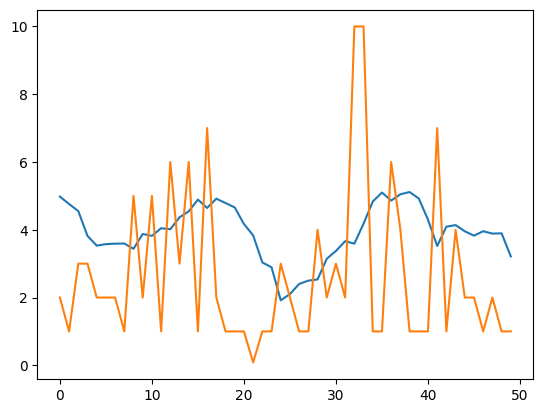

In [188]:
plt.plot(train_result['train'][:50])
plt.plot(train_result['Actual'][:50])